In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from dotenv import load_dotenv
import os


In [2]:
#API KEYS
load_dotenv()

bls_api = os.getenv("bls_api")
bea_api = os.getenv("bea_api")


In [3]:
#URLS

url_bea = "https://apps.bea.gov/api/data"
url_bls = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

In [4]:
#Datos para demsempleo por Estado
estados = {
    "Alabama": "LAUST010000000000003",
    "Alaska": "LAUST020000000000003",
    "Arizona": "LAUST040000000000003",
    "Arkansas": "LAUST050000000000003",
    "California": "LAUST060000000000003",
    "Colorado": "LAUST080000000000003",
    "Connecticut": "LAUST090000000000003",
    "Delaware": "LAUST100000000000003",
    "Florida": "LAUST120000000000003",
    "Georgia": "LAUST130000000000003",
    "Hawaii": "LAUST150000000000003",
    "Idaho": "LAUST160000000000003",
    "Illinois": "LAUST170000000000003",
    "Indiana": "LAUST180000000000003",
    "Iowa": "LAUST190000000000003",
    "Kansas": "LAUST200000000000003",
    "Kentucky": "LAUST210000000000003",
    "Louisiana": "LAUST220000000000003",
    "Maine": "LAUST230000000000003",
    "Maryland": "LAUST240000000000003",
    "Massachusetts": "LAUST250000000000003",
    "Michigan": "LAUST260000000000003",
    "Minnesota": "LAUST270000000000003",
    "Mississippi": "LAUST280000000000003",
    "Missouri": "LAUST290000000000003",
    "Montana": "LAUST300000000000003",
    "Nebraska": "LAUST310000000000003",
    "Nevada": "LAUST320000000000003",
    "New Hampshire": "LAUST330000000000003",
    "New Jersey": "LAUST340000000000003",
    "New Mexico": "LAUST350000000000003",
    "New York": "LAUST360000000000003",
    "North Carolina": "LAUST370000000000003",
    "North Dakota": "LAUST380000000000003",
    "Ohio": "LAUST390000000000003",
    "Oklahoma": "LAUST400000000000003",
    "Oregon": "LAUST410000000000003",
    "Pennsylvania": "LAUST420000000000003",
    "Rhode Island": "LAUST440000000000003",
    "South Carolina": "LAUST450000000000003",
    "South Dakota": "LAUST460000000000003",
    "Tennessee": "LAUST470000000000003",
    "Texas": "LAUST480000000000003",
    "Utah": "LAUST490000000000003",
    "Vermont": "LAUST500000000000003",
    "Virginia": "LAUST510000000000003",
    "Washington": "LAUST530000000000003",
    "West Virginia": "LAUST540000000000003",
    "Wisconsin": "LAUST550000000000003",
    "Wyoming": "LAUST560000000000003"
}

In [5]:
meses = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

In [6]:
rangos = [(1990,1999),(2000, 2009), (2010, 2019), (2020, 2025)]

In [7]:
#Payload
registros = []

series = list(estados.values())

for start, end in rangos:
    for i in range(0, len(series), 25):  
        bloque = series[i:i+25]
        payload = {
            "registrationKey": bls_api,
            "seriesid": bloque,
            "startyear": str(start),
            "endyear": str(end)
        }
        url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
        response = requests.post(url, json=payload)
        data = response.json()

        # Procesar cada serie
        for serie in data["Results"]["series"]:
            estado = [k for k, v in estados.items() if v == serie["seriesID"]][0]
            for d in serie["data"]:
                if d["periodName"] in meses:
                    registros.append({
                        "Estado": estado,
                        "Año": int(d["year"]),
                        "Mes": meses[d["periodName"]],
                        "TasaDesempleo": float(d["value"])
                    })
        time.sleep(0.5)  # pequeño delay para no saturar la API


In [8]:
df = pd.DataFrame(registros)
df["Fecha"] = pd.to_datetime(df["Año"].astype(str) + "-" + df["Mes"].astype(str).str.zfill(2))
df = df.sort_values(["Estado", "Fecha"]).reset_index(drop=True)
df = df[df['Estado'] != 'New York city']
df = df[df['Estado'] != 'Los Angeles County']
df = df[['Estado','Fecha','TasaDesempleo']]
df['Trim'] = df['Fecha'].dt.to_period('Q').astype(str)
df

,Estado,Fecha,TasaDesempleo,Trim
0,Alabama,1990-01-01,7.1,1990Q1
1,Alabama,1990-02-01,7.3,1990Q1
2,Alabama,1990-03-01,6.6,1990Q1
3,Alabama,1990-04-01,6.4,1990Q2
4,Alabama,1990-05-01,6.3,1990Q2
...,...,...,...,...
21395,Wyoming,2025-04-01,3.0,2025Q2
21396,Wyoming,2025-05-01,3.2,2025Q2
21397,Wyoming,2025-06-01,3.7,2025Q2
21398,Wyoming,2025-07-01,2.8,2025Q3


In [9]:
#Parametros para GDP

params = {
    "UserID": bea_api,
    "method": "GetData",
    "datasetname": "Regional",
    "TableName": "SQGDP1",   
    "Frequency": "Q",
    "Year": "ALL",    
    'GeoFips':'STATE',     
    "ResultFormat": "JSON",
    'LineCode':1
}

In [10]:
#Request GDP
response = requests.get(url_bea, params=params)
response.status_code == 200

True

In [11]:
gdp = response.json()
gdp

{'BEAAPI': {'Request': {'RequestParam': [{'ParameterName': 'USERID',
     'ParameterValue': '1877DB8B-6730-4F80-B187-242ACB99D57C'},
    {'ParameterName': 'METHOD', 'ParameterValue': 'GETDATA'},
    {'ParameterName': 'DATASETNAME', 'ParameterValue': 'REGIONAL'},
    {'ParameterName': 'TABLENAME', 'ParameterValue': 'SQGDP1'},
    {'ParameterName': 'FREQUENCY', 'ParameterValue': 'Q'},
    {'ParameterName': 'YEAR', 'ParameterValue': 'ALL'},
    {'ParameterName': 'GEOFIPS', 'ParameterValue': 'STATE'},
    {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'},
    {'ParameterName': 'LINECODE', 'ParameterValue': '1'}]},
  'Results': {'Statistic': 'Real Gross Domestic Product (GDP)',
   'UnitOfMeasure': 'Millions of chained 2017 dollars',
   'PublicTable': 'SQGDP1 State quarterly gross domestic product (GDP) summary',
   'UTCProductionTime': '2025-11-28T11:28:12.970',
   'NoteRef': '1',
   'Dimensions': [{'Name': 'Code', 'DataType': 'string', 'IsValue': '0'},
    {'Name': 'GeoFips', 'Da

In [12]:
records = gdp['BEAAPI']['Results']['Data']
records

[{'Code': 'SQGDP1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2023Q4',
  'CL_UNIT': 'Millions of chained 2017 dollars',
  'UNIT_MULT': '6',
  'DataValue': '23033780.0',
  'NoteRef': '1'},
 {'Code': 'SQGDP1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2025Q1',
  'CL_UNIT': 'Millions of chained 2017 dollars',
  'UNIT_MULT': '6',
  'DataValue': '23548210.0',
  'NoteRef': '1'},
 {'Code': 'SQGDP1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2024Q1',
  'CL_UNIT': 'Millions of chained 2017 dollars',
  'UNIT_MULT': '6',
  'DataValue': '23082119.0',
  'NoteRef': '1'},
 {'Code': 'SQGDP1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2024Q4',
  'CL_UNIT': 'Millions of chained 2017 dollars',
  'UNIT_MULT': '6',
  'DataValue': '23586542.0',
  'NoteRef': '1'},
 {'Code': 'SQGDP1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2007Q1',
  'CL_UNIT': 'Millions of chaine

In [13]:
gdp_data = pd.DataFrame(records)[['GeoName','TimePeriod','DataValue']]
gdp_data[gdp_data['GeoName']=='United States']
gdp_data

,GeoName,TimePeriod,DataValue
0,United States,2023Q4,23033780.0
1,United States,2025Q1,23548210.0
2,United States,2024Q1,23082119.0
3,United States,2024Q4,23586542.0
4,United States,2007Q1,16611690.0
...,...,...,...
4915,Far West,2024Q3,4649588.3
4916,Far West,2024Q2,4606652.1
4917,Far West,2024Q1,4574901.3
4918,Far West,2023Q4,4541655.7


In [14]:
gdp_data["DataValue"] = pd.to_numeric(gdp_data["DataValue"], errors="coerce")
gdp_data.rename(columns={'GeoName':'Estado','TimePeriod':'Trim','DataValue':'GDP'}, inplace=True)
gdp_data

,Estado,Trim,GDP
0,United States,2023Q4,23033780.0
1,United States,2025Q1,23548210.0
2,United States,2024Q1,23082119.0
3,United States,2024Q4,23586542.0
4,United States,2007Q1,16611690.0
...,...,...,...
4915,Far West,2024Q3,4649588.3
4916,Far West,2024Q2,4606652.1
4917,Far West,2024Q1,4574901.3
4918,Far West,2023Q4,4541655.7


In [15]:
base_cox = pd.merge(
    df,
    gdp_data[['Estado','Trim','GDP']],
    on=['Estado','Trim'],
    how='left'
)
base_cox

,Estado,Fecha,TasaDesempleo,Trim,GDP
0,Alabama,1990-01-01,7.1,1990Q1,NaN
1,Alabama,1990-02-01,7.3,1990Q1,NaN
2,Alabama,1990-03-01,6.6,1990Q1,NaN
3,Alabama,1990-04-01,6.4,1990Q2,NaN
4,Alabama,1990-05-01,6.3,1990Q2,NaN
...,...,...,...,...,...
21395,Wyoming,2025-04-01,3.0,2025Q2,39982.7
21396,Wyoming,2025-05-01,3.2,2025Q2,39982.7
21397,Wyoming,2025-06-01,3.7,2025Q2,39982.7
21398,Wyoming,2025-07-01,2.8,2025Q3,NaN


In [16]:
#Parametros Personla Income
params_pi = {
    "UserID": bea_api,
    "method": "GetData",
    "datasetname": "Regional",
    "TableName": "SQINC1",   
    "Frequency": "Q",
    "Year": "ALL",    
    'GeoFips':'STATE',     
    "ResultFormat": "JSON",
    'LineCode':1
}

In [17]:
#Request 
response_pi = requests.get(url_bea, params=params_pi)
response_pi.status_code == 200

True

In [18]:
pi = response_pi.json()
pi

{'BEAAPI': {'Request': {'RequestParam': [{'ParameterName': 'USERID',
     'ParameterValue': '1877DB8B-6730-4F80-B187-242ACB99D57C'},
    {'ParameterName': 'METHOD', 'ParameterValue': 'GETDATA'},
    {'ParameterName': 'DATASETNAME', 'ParameterValue': 'REGIONAL'},
    {'ParameterName': 'TABLENAME', 'ParameterValue': 'SQINC1'},
    {'ParameterName': 'FREQUENCY', 'ParameterValue': 'Q'},
    {'ParameterName': 'YEAR', 'ParameterValue': 'ALL'},
    {'ParameterName': 'GEOFIPS', 'ParameterValue': 'STATE'},
    {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'},
    {'ParameterName': 'LINECODE', 'ParameterValue': '1'}]},
  'Results': {'Statistic': 'Personal income',
   'UnitOfMeasure': 'Millions of dollars',
   'PublicTable': 'SQINC1 State quarterly personal income summary: personal income, population, per capita personal income',
   'UTCProductionTime': '2025-11-28T11:28:15.797',
   'NoteRef': ' ',
   'Dimensions': [{'Name': 'Code', 'DataType': 'string', 'IsValue': '0'},
    {'Name': '

In [19]:
records_pi = pi['BEAAPI']['Results']['Data']
records_pi

[{'Code': 'SQINC1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2023Q3',
  'CL_UNIT': 'Millions of dollars',
  'UNIT_MULT': '6',
  'DataValue': '23724337.7'},
 {'Code': 'SQINC1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '1989Q4',
  'CL_UNIT': 'Millions of dollars',
  'UNIT_MULT': '6',
  'DataValue': '4702517.8'},
 {'Code': 'SQINC1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2023Q2',
  'CL_UNIT': 'Millions of dollars',
  'UNIT_MULT': '6',
  'DataValue': '23454699.2'},
 {'Code': 'SQINC1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2000Q2',
  'CL_UNIT': 'Millions of dollars',
  'UNIT_MULT': '6',
  'DataValue': '8550011.9'},
 {'Code': 'SQINC1-1',
  'GeoFips': '00000',
  'GeoName': 'United States',
  'TimePeriod': '2023Q1',
  'CL_UNIT': 'Millions of dollars',
  'UNIT_MULT': '6',
  'DataValue': '23109259.4'},
 {'Code': 'SQINC1-1',
  'GeoFips': '00000',
  'GeoName': 'United States'

In [20]:
data_pi = pd.DataFrame(records_pi)[['GeoName','TimePeriod','DataValue']]
data_pi

,GeoName,TimePeriod,DataValue
0,United States,2023Q3,23724337.7
1,United States,1989Q4,4702517.8
2,United States,2023Q2,23454699.2
3,United States,2000Q2,8550011.9
4,United States,2023Q1,23109259.4
...,...,...,...
18595,Far West *,2024Q1,4667147.0
18596,Far West *,2024Q2,4739480.1
18597,Far West *,2024Q3,4788860.9
18598,Far West *,2024Q4,4876382.7


In [21]:
data_pi['DataValue'] = pd.to_numeric(data_pi['DataValue'],errors='coerce')
data_pi.rename(columns={'GeoName':'Estado','TimePeriod':'Trim','DataValue':'Personal_Income'}, inplace=True)
data_pi["Estado"] = data_pi["Estado"].str.replace("*", "", regex=False).str.strip()
data_pi


,Estado,Trim,Personal_Income
0,United States,2023Q3,23724337.7
1,United States,1989Q4,4702517.8
2,United States,2023Q2,23454699.2
3,United States,2000Q2,8550011.9
4,United States,2023Q1,23109259.4
...,...,...,...
18595,Far West,2024Q1,4667147.0
18596,Far West,2024Q2,4739480.1
18597,Far West,2024Q3,4788860.9
18598,Far West,2024Q4,4876382.7


In [22]:
base_cox = pd.merge(
    base_cox,
    data_pi[['Estado','Trim','Personal_Income']],
    on=['Estado','Trim'],
    how='left'
)

In [23]:
#Separacion por zonas
state_abbr = {
    "Alabama":"AL", "Alaska":"AK", "Arizona":"AZ", "Arkansas":"AR", "California":"CA",
    "Colorado":"CO", "Connecticut":"CT", "Delaware":"DE", "DistrictOfColumbia":"DC",
    "Florida":"FL", "Georgia":"GA", "Hawaii":"HI", "Idaho":"ID", "Illinois":"IL",
    "Indiana":"IN", "Iowa":"IA", "Kansas":"KS", "Kentucky":"KY", "Louisiana":"LA",
    "Maine":"ME", "Maryland":"MD", "Massachusetts":"MA", "Michigan":"MI",
    "Minnesota":"MN", "Mississippi":"MS", "Missouri":"MO", "Montana":"MT",
    "Nebraska":"NE", "Nevada":"NV", "NewHampshire":"NH", "NewJersey":"NJ",
    "NewMexico":"NM", "NewYork":"NY", "NorthCarolina":"NC", "NorthDakota":"ND",
    "Ohio":"OH", "Oklahoma":"OK", "Oregon":"OR", "Pennsylvania":"PA",
    "RhodeIsland":"RI", "SouthCarolina":"SC", "SouthDakota":"SD", "Tennessee":"TN",
    "Texas":"TX", "Utah":"UT", "Vermont":"VT", "Virginia":"VA", "Washington":"WA",
    "WestVirginia":"WV", "Wisconsin":"WI", "Wyoming":"WY"
}



In [24]:
base_cox['Abr'] = base_cox['Estado'].map(state_abbr)
#base_cox['region'] = base_cox['Abr'].map(state_region_map)
base_cox

,Estado,Fecha,TasaDesempleo,Trim,GDP,Personal_Income,Abr
0,Alabama,1990-01-01,7.1,1990Q1,NaN,62823.1,AL
1,Alabama,1990-02-01,7.3,1990Q1,NaN,62823.1,AL
2,Alabama,1990-03-01,6.6,1990Q1,NaN,62823.1,AL
3,Alabama,1990-04-01,6.4,1990Q2,NaN,64011.2,AL
4,Alabama,1990-05-01,6.3,1990Q2,NaN,64011.2,AL
...,...,...,...,...,...,...,...
21395,Wyoming,2025-04-01,3.0,2025Q2,39982.7,52880.9,WY
21396,Wyoming,2025-05-01,3.2,2025Q2,39982.7,52880.9,WY
21397,Wyoming,2025-06-01,3.7,2025Q2,39982.7,52880.9,WY
21398,Wyoming,2025-07-01,2.8,2025Q3,NaN,NaN,WY


In [25]:
base_cox['U_3m'] = base_cox.groupby('Estado')['TasaDesempleo'].transform(lambda x: x.rolling(3, min_periods = 3).mean().round(2))
base_cox['U_min12']= base_cox.groupby('Estado')['U_3m'].transform(lambda x: x.rolling(12, min_periods = 12).min().round(2))
base_cox['SahmRule'] = (base_cox['U_3m']-base_cox['U_min12']).round(2)
base_cox['Dummy'] = (base_cox['SahmRule'] >=0.5).astype(int)
base_cox['Fecha'] = pd.PeriodIndex(base_cox['Trim'], freq='Q').to_timestamp()
base_cox

,Estado,Fecha,TasaDesempleo,Trim,GDP,Personal_Income,Abr,U_3m,U_min12,SahmRule,Dummy
0,Alabama,1990-01-01,7.1,1990Q1,NaN,62823.1,AL,NaN,NaN,NaN,0
1,Alabama,1990-01-01,7.3,1990Q1,NaN,62823.1,AL,NaN,NaN,NaN,0
2,Alabama,1990-01-01,6.6,1990Q1,NaN,62823.1,AL,7.00,NaN,NaN,0
3,Alabama,1990-04-01,6.4,1990Q2,NaN,64011.2,AL,6.77,NaN,NaN,0
4,Alabama,1990-04-01,6.3,1990Q2,NaN,64011.2,AL,6.43,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
21395,Wyoming,2025-04-01,3.0,2025Q2,39982.7,52880.9,WY,3.47,2.97,0.50,1
21396,Wyoming,2025-04-01,3.2,2025Q2,39982.7,52880.9,WY,3.30,2.97,0.33,0
21397,Wyoming,2025-04-01,3.7,2025Q2,39982.7,52880.9,WY,3.30,2.97,0.33,0
21398,Wyoming,2025-07-01,2.8,2025Q3,NaN,NaN,WY,3.23,2.97,0.26,0


In [26]:
base_cox

,Estado,Fecha,TasaDesempleo,Trim,GDP,Personal_Income,Abr,U_3m,U_min12,SahmRule,Dummy
0,Alabama,1990-01-01,7.1,1990Q1,NaN,62823.1,AL,NaN,NaN,NaN,0
1,Alabama,1990-01-01,7.3,1990Q1,NaN,62823.1,AL,NaN,NaN,NaN,0
2,Alabama,1990-01-01,6.6,1990Q1,NaN,62823.1,AL,7.00,NaN,NaN,0
3,Alabama,1990-04-01,6.4,1990Q2,NaN,64011.2,AL,6.77,NaN,NaN,0
4,Alabama,1990-04-01,6.3,1990Q2,NaN,64011.2,AL,6.43,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
21395,Wyoming,2025-04-01,3.0,2025Q2,39982.7,52880.9,WY,3.47,2.97,0.50,1
21396,Wyoming,2025-04-01,3.2,2025Q2,39982.7,52880.9,WY,3.30,2.97,0.33,0
21397,Wyoming,2025-04-01,3.7,2025Q2,39982.7,52880.9,WY,3.30,2.97,0.33,0
21398,Wyoming,2025-07-01,2.8,2025Q3,NaN,NaN,WY,3.23,2.97,0.26,0


In [27]:
base_cox_kaplan = base_cox
base_cox_kaplan
%store base_cox_kaplan
base_cox_kaplan


Stored 'base_cox_kaplan' (DataFrame)


,Estado,Fecha,TasaDesempleo,Trim,GDP,Personal_Income,Abr,U_3m,U_min12,SahmRule,Dummy
0,Alabama,1990-01-01,7.1,1990Q1,NaN,62823.1,AL,NaN,NaN,NaN,0
1,Alabama,1990-01-01,7.3,1990Q1,NaN,62823.1,AL,NaN,NaN,NaN,0
2,Alabama,1990-01-01,6.6,1990Q1,NaN,62823.1,AL,7.00,NaN,NaN,0
3,Alabama,1990-04-01,6.4,1990Q2,NaN,64011.2,AL,6.77,NaN,NaN,0
4,Alabama,1990-04-01,6.3,1990Q2,NaN,64011.2,AL,6.43,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
21395,Wyoming,2025-04-01,3.0,2025Q2,39982.7,52880.9,WY,3.47,2.97,0.50,1
21396,Wyoming,2025-04-01,3.2,2025Q2,39982.7,52880.9,WY,3.30,2.97,0.33,0
21397,Wyoming,2025-04-01,3.7,2025Q2,39982.7,52880.9,WY,3.30,2.97,0.33,0
21398,Wyoming,2025-07-01,2.8,2025Q3,NaN,NaN,WY,3.23,2.97,0.26,0


In [28]:
base_cox = base_cox[base_cox['Fecha']>='2007-09-01']
base_cox = base_cox[base_cox['Fecha']<='2010-12-31']
base_cox['GDP'] = np.log(base_cox['GDP'])
base_cox['Personal_Income']=np.log(base_cox['Personal_Income'])
base_cox =  base_cox[['Estado','Trim','Fecha','TasaDesempleo','Personal_Income','GDP','SahmRule','Dummy']]
base_cox.reset_index(drop=True)

,Estado,Trim,Fecha,TasaDesempleo,Personal_Income,GDP,SahmRule,Dummy
0,Alabama,2007Q4,2007-10-01,3.9,11.944742,12.223257,0.53,1
1,Alabama,2007Q4,2007-10-01,4.1,11.944742,12.223257,0.46,0
2,Alabama,2007Q4,2007-10-01,4.4,11.944742,12.223257,0.56,1
3,Alabama,2008Q1,2008-01-01,5.1,11.951368,12.218838,0.96,1
4,Alabama,2008Q1,2008-01-01,5.0,11.951368,12.218838,1.26,1
...,...,...,...,...,...,...,...,...
1945,Wyoming,2010Q3,2010-07-01,6.2,10.186939,10.587316,0.03,0
1946,Wyoming,2010Q3,2010-07-01,6.0,10.186939,10.587316,0.00,0
1947,Wyoming,2010Q4,2010-10-01,6.0,10.199948,10.575010,0.00,0
1948,Wyoming,2010Q4,2010-10-01,6.5,10.199948,10.575010,0.10,0


In [29]:
# Agrupar por Estado y Trimestre, dejando un registro por trimestre
base_cox = (base_cox
    .groupby(['Estado', 'Trim'], as_index=False)
    .agg({
        'GDP':'mean',
        'TasaDesempleo': 'mean',
        'Personal_Income': 'mean',
        'SahmRule': 'mean',
        'Dummy': 'max'
    })
)

# Volver a generar la columna de fecha
base_cox['Fecha'] = pd.PeriodIndex(base_cox['Trim'], freq='Q').to_timestamp()

In [30]:
base_cox['recession_start'] = (
    (base_cox['Dummy'] == 1) &
    ((base_cox['Dummy'].shift(1) == 0) | (base_cox['Estado'] != base_cox['Estado'].shift(1)))
)
base_cox

,Estado,Trim,GDP,TasaDesempleo,Personal_Income,SahmRule,Dummy,Fecha,recession_start
0,Alabama,2007Q4,12.223257,4.133333,11.944742,0.516667,1,2007-10-01,True
1,Alabama,2008Q1,12.218838,5.000000,11.951368,1.216667,1,2008-01-01,False
2,Alabama,2008Q2,12.223525,5.200000,11.996815,1.133333,1,2008-04-01,False
3,Alabama,2008Q3,12.215361,6.400000,11.968071,2.146667,1,2008-07-01,False
4,Alabama,2008Q4,12.185424,7.000000,11.958987,2.503333,1,2008-10-01,False
...,...,...,...,...,...,...,...,...,...
645,Wyoming,2009Q4,10.545289,7.133333,10.096819,3.376667,1,2009-10-01,False
646,Wyoming,2010Q1,10.561624,8.133333,10.140325,2.620000,1,2010-01-01,False
647,Wyoming,2010Q2,10.575061,6.833333,10.163588,1.183333,1,2010-04-01,False
648,Wyoming,2010Q3,10.587316,6.200000,10.186939,0.076667,0,2010-07-01,False


In [31]:
base_cox['recession_end'] = (
    (base_cox['Dummy'] == 0) &
    (base_cox['Dummy'].shift(1) == 1) &
    (base_cox['Estado'] == base_cox['Estado'].shift(1))
)
base_cox

,Estado,Trim,GDP,TasaDesempleo,Personal_Income,SahmRule,Dummy,Fecha,recession_start,recession_end
0,Alabama,2007Q4,12.223257,4.133333,11.944742,0.516667,1,2007-10-01,True,False
1,Alabama,2008Q1,12.218838,5.000000,11.951368,1.216667,1,2008-01-01,False,False
2,Alabama,2008Q2,12.223525,5.200000,11.996815,1.133333,1,2008-04-01,False,False
3,Alabama,2008Q3,12.215361,6.400000,11.968071,2.146667,1,2008-07-01,False,False
4,Alabama,2008Q4,12.185424,7.000000,11.958987,2.503333,1,2008-10-01,False,False
...,...,...,...,...,...,...,...,...,...,...
645,Wyoming,2009Q4,10.545289,7.133333,10.096819,3.376667,1,2009-10-01,False,False
646,Wyoming,2010Q1,10.561624,8.133333,10.140325,2.620000,1,2010-01-01,False,False
647,Wyoming,2010Q2,10.575061,6.833333,10.163588,1.183333,1,2010-04-01,False,False
648,Wyoming,2010Q3,10.587316,6.200000,10.186939,0.076667,0,2010-07-01,False,True


In [32]:
base_cox[base_cox['Estado']=='Alaska']

,Estado,Trim,GDP,TasaDesempleo,Personal_Income,SahmRule,Dummy,Fecha,recession_start,recession_end
13,Alaska,2007Q4,10.813452,6.133333,10.314491,0.330000,1,2007-10-01,True,False
14,Alaska,2008Q1,10.790352,7.133333,10.372550,1.453333,1,2008-01-01,False,False
15,Alaska,2008Q2,10.768015,6.500000,10.407074,1.230000,1,2008-04-01,False,False
16,Alaska,2008Q3,10.810697,5.766667,10.405756,0.553333,1,2008-07-01,False,False
17,Alaska,2008Q4,10.899153,6.566667,10.414228,0.420000,1,2008-10-01,False,False
18,Alaska,2009Q1,10.938111,8.400000,10.390287,2.086667,1,2009-01-01,False,False
19,Alaska,2009Q2,10.924776,7.900000,10.402580,2.320000,1,2009-04-01,False,False
20,Alaska,2009Q3,10.901229,7.100000,10.404651,1.576667,1,2009-07-01,False,False
21,Alaska,2009Q4,10.892071,8.000000,10.418775,1.053333,1,2009-10-01,False,False
22,Alaska,2010Q1,10.867051,9.333333,10.448016,1.823333,1,2010-01-01,False,False


In [33]:
%store base_cox

Stored 'base_cox' (DataFrame)


In [34]:
state_region_map = {
    # --- NORTE ---
    "ME": "Norte", "NH": "Norte", "VT": "Norte", "MA": "Norte", "RI": "Norte", "CT": "Norte",
    "NY": "Norte", "NJ": "Norte", "PA": "Norte", "OH": "Norte", "MI": "Norte", "WI": "Norte",
    "MN": "Norte", "ND": "Norte", "SD": "Norte",

    # --- ESTE ---
    "DE": "Este", "MD": "Este", "DC": "Este", "VA": "Este", "WV": "Este", 
    "NC": "Este", "SC": "Este", "GA": "Este", "FL": "Este",

    # --- CENTRO ---
    "IL": "Centro", "IN": "Centro", "IA": "Centro", "MO": "Centro",
    "KS": "Centro", "NE": "Centro", "KY": "Centro", "TN": "Centro", "AR": "Centro",

    # --- SUR ---
    "AL": "Sur", "MS": "Sur", "LA": "Sur", "TX": "Sur", "OK": "Sur", 
    "NM": "Sur", "AZ": "Sur",

    # --- OESTE ---
    "CO": "Oeste", "UT": "Oeste", "NV": "Oeste", "CA": "Oeste", 
    "OR": "Oeste", "WA": "Oeste", "ID": "Oeste", "MT": "Oeste", "WY": "Oeste", "AK": "Oeste", "HI": "Oeste"

}

state_abbr = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}



In [35]:
base_cox['Abr'] = base_cox['Estado'].map(state_abbr)
base_cox

,Estado,Trim,GDP,TasaDesempleo,Personal_Income,SahmRule,Dummy,Fecha,recession_start,recession_end,Abr
0,Alabama,2007Q4,12.223257,4.133333,11.944742,0.516667,1,2007-10-01,True,False,AL
1,Alabama,2008Q1,12.218838,5.000000,11.951368,1.216667,1,2008-01-01,False,False,AL
2,Alabama,2008Q2,12.223525,5.200000,11.996815,1.133333,1,2008-04-01,False,False,AL
3,Alabama,2008Q3,12.215361,6.400000,11.968071,2.146667,1,2008-07-01,False,False,AL
4,Alabama,2008Q4,12.185424,7.000000,11.958987,2.503333,1,2008-10-01,False,False,AL
...,...,...,...,...,...,...,...,...,...,...,...
645,Wyoming,2009Q4,10.545289,7.133333,10.096819,3.376667,1,2009-10-01,False,False,WY
646,Wyoming,2010Q1,10.561624,8.133333,10.140325,2.620000,1,2010-01-01,False,False,WY
647,Wyoming,2010Q2,10.575061,6.833333,10.163588,1.183333,1,2010-04-01,False,False,WY
648,Wyoming,2010Q3,10.587316,6.200000,10.186939,0.076667,0,2010-07-01,False,True,WY


In [36]:
alaska = base_cox[base_cox['Estado']=='Alaska']
hawaii = base_cox[base_cox['Estado']=='Hawaii']

In [37]:
import geopandas as gpd

In [38]:
shapefile_path = 'map'
states = gpd.read_file(shapefile_path)
states = states.rename(columns={'name':'Estado'})
states[states['Estado']=='Texas']

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,Estado,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
22,Admin-1 scale rank,2,USA-3536,3536,US-TX,http://en.wikipedia.org/wiki/Texas,US,4,Texas,TX|Tex.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-106.50734 31.75429, -106.61953 31.9..."


In [41]:
sahm_state_total = base_cox.groupby(by = 'Estado')['Dummy'].sum().reset_index()
sahm_state_total
sahm_state_total[sahm_state_total['Estado']=='North Dakota']

,Estado,Dummy
33,North Dakota,9


In [ ]:
states = states.merge(sahm_state_total, on='Estado', how='left')
states['Abr'] = states['Estado'].map(state_abbr)
alaska = states[states['Estado']=='Alaska']
hawaii = states[states['Estado']=='Hawaii']
states = states[~states['Estado'].isin(['Alaska','Hawaii','DistrictOfColumbia'])]
states


,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,Estado,name_alt,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry,Dummy,Abr
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",11.0,MN
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",11.0,MT
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",9.0,ND
4,Admin-1 scale rank,2,USA-3518,3518,US-ID,http://en.wikipedia.org/wiki/Idaho,US,1,Idaho,ID|Idaho,...,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -115.9678 47.95...",11.0,ID
5,Admin-1 scale rank,2,USA-3519,3519,US-WA,http://en.wikipedia.org/wiki/Washington_(state),US,6,Washington,WA|Wash.,...,None,None,None,None,None,None,None,"POLYGON ((-117.03143 48.99931, -117.02665 47.7...",10.0,WA
6,Admin-1 scale rank,2,USA-3520,3520,US-AZ,http://en.wikipedia.org/wiki/Arizona,US,1,Arizona,AZ|Ariz.,...,None,None,None,None,None,None,None,"POLYGON ((-109.04522 36.99991, -109.04367 31.3...",12.0,AZ
7,Admin-1 scale rank,2,USA-3521,3521,US-CA,http://en.wikipedia.org/wiki/California,US,8,California,CA|Calif.,...,None,None,None,None,None,None,None,"POLYGON ((-114.64222 35.05311, -114.62212 34.9...",12.0,CA
8,Admin-1 scale rank,2,USA-3522,3522,US-CO,http://en.wikipedia.org/wiki/Colorado,US,1,Colorado,CO|Colo.,...,None,None,None,None,None,None,None,"POLYGON ((-102.05017 40.00081, -102.04012 38.4...",12.0,CO
9,Admin-1 scale rank,2,USA-3523,3523,US-NV,http://en.wikipedia.org/wiki/Nevada,US,1,Nevada,NV|Nev.,...,None,None,None,None,None,None,None,"POLYGON ((-117.02825 42.00002, -114.03422 41.9...",13.0,NV
10,Admin-1 scale rank,2,USA-3524,3524,US-NM,http://en.wikipedia.org/wiki/New_Mexico,US,1,New Mexico,NM|N.M.,...,None,None,None,None,None,None,None,"POLYGON ((-109.04367 31.3419, -109.04522 36.99...",11.0,NM


C:\Users\jleal\AppData\Local\Temp\ipykernel_30512\3052943503.py:28: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  alaska.plot(ax=ax_ak, column='Dummy',color='#8b0000')
C:\Users\jleal\AppData\Local\Temp\ipykernel_30512\3052943503.py:36: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii.plot(ax=ax_hi, column='Dummy', color = '#fb694a')


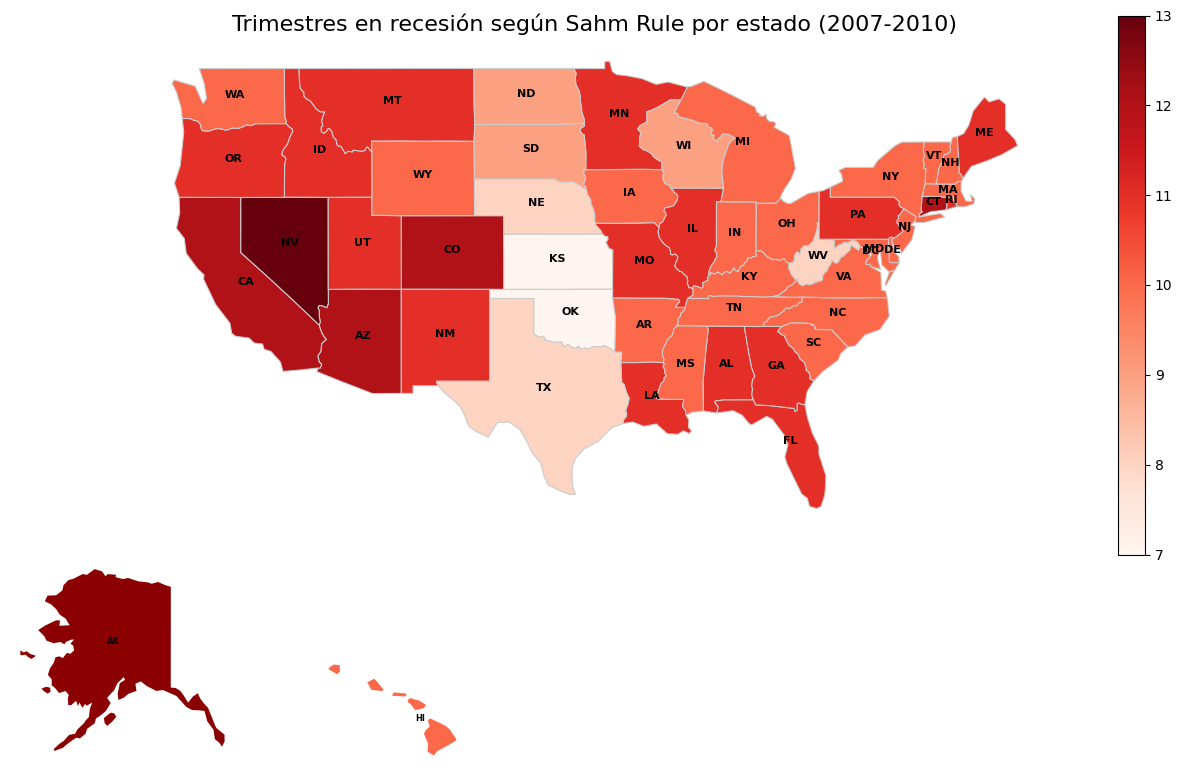

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
states.plot(
    column='Dummy', 
    cmap='Reds', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='0.8', 
    legend=True,
    legend_kwds={
        'shrink':0.7
    }
)

for idx, row in states.iterrows():
    if row['geometry'].geom_type == 'Polygon': 
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
        ax.text(x, y, row['Abr'], horizontalalignment='center', fontsize=8, fontweight='bold')
    elif row['geometry'].geom_type == 'MultiPolygon': 
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
        ax.text(x, y, row['Abr'], horizontalalignment='center', fontsize=8, fontweight='bold')


ax.set_title('Trimestres en recesión según Sahm Rule por estado (2007-2010)', fontsize=16)
ax.axis('off')

# Crear un axes pequeño
ax_ak = fig.add_axes([0.02, 0.02, 0.2, 0.2])  # posición y tamaño del inset
alaska.plot(ax=ax_ak, column='Dummy',color='#8b0000')
for idx, row in alaska.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax_ak.text(x, y, row['Abr'], horizontalalignment='center', fontsize=6, fontweight='bold')
ax_ak.axis('off')
# Repetir para Hawaii
ax_hi = fig.add_axes([0.25, 0.02, 0.1, 0.1])

hawaii.plot(ax=ax_hi, column='Dummy', color = '#fb694a')
for idx, row in hawaii.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax_hi.text(x, y, row['Abr'], horizontalalignment='center', fontsize=6, fontweight='bold')
ax_hi.axis('off')

plt.show()
#plt.tight_layout()